## Parser_util.py

Se crea un argument parser usando la librería argparse para definir los argumentos que pueden pasar al script desde la línea de comandos.

In [50]:
# coding=utf-8
import os
import argparse


def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('-root', '--dataset_root',
                        type=str,
                        help='path to dataset',
                        default='..' + os.sep + 'dataset')

    parser.add_argument('-exp', '--experiment_root',
                        type=str,
                        help='root where to store models, losses and accuracies',
                        default='..' + os.sep + 'output')

    parser.add_argument('-nep', '--epochs',
                        type=int,
                        help='number of epochs to train for',
                        default=9)

    parser.add_argument('-lr', '--learning_rate',
                        type=float,
                        help='learning rate for the model, default=0.001',
                        default=0.001)

    parser.add_argument('-lrS', '--lr_scheduler_step',
                        type=int,
                        help='StepLR learning rate scheduler step, default=20',
                        default=5)

    parser.add_argument('-lrG', '--lr_scheduler_gamma',
                        type=float,
                        help='StepLR learning rate scheduler gamma, default=0.5',
                        default=0.5)

    parser.add_argument('-its', '--iterations',
                        type=int,
                        help='number of episodes per epoch, default=100',
                        default=100)

    parser.add_argument('-cTr', '--classes_per_it_tr',
                        type=int,
                        help='number of random classes per episode for training, default=60',
                        default=10)

    parser.add_argument('-nsTr', '--num_support_tr',
                        type=int,
                        help='number of samples per class to use as support for training, default=5',
                        default=5)

    parser.add_argument('-nqTr', '--num_query_tr',
                        type=int,
                        help='number of samples per class to use as query for training, default=5',
                        default=5)

    parser.add_argument('-cVa', '--classes_per_it_val',
                        type=int,
                        help='number of random classes per episode for validation, default=5',
                        default=10)

    parser.add_argument('-nsVa', '--num_support_val',
                        type=int,
                        help='number of samples per class to use as support for validation, default=5',
                        default=5)

    parser.add_argument('-nqVa', '--num_query_val',
                        type=int,
                        help='number of samples per class to use as query for validation, default=15',
                        default=15)

    parser.add_argument('-seed', '--manual_seed',
                        type=int,
                        help='input for the manual seeds initializations',
                        default=7)

    parser.add_argument('--cuda',
                        action='store_true',
                        help='enables cuda')

    return parser


## Protonet.py

Modelo basado en Prototypical Networks, una arquitectura utilizada para Few-Shot Learning.

In [15]:
import torch.nn as nn
import torch

# Devuelve un bloque de convolución
def conv_block(in_channels, out_channels):
    '''
    returns a block conv-bn-relu-pool
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )



# Convierte imágenes en embeddings
class ProtoNet(nn.Module):
    def __init__(self, x_dim=1, hid_dim=64, z_dim=10):
        super(ProtoNet, self).__init__()
        self.encoder = nn.Sequential(
            conv_block(x_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, z_dim),
        )
        #self.fc = nn.Linear(z_dim, 10)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        # x = self.fc(x)
        return x

    # Calcula prototipos de cada clase
    def get_prototypes(self, embeddings, labels, n_support):
        unique_labels = torch.unique(labels)
        prototypes = []
        
        for label in unique_labels:
            class_samples = embeddings[labels == label][:n_support]
            class_prototype = class_samples.mean(dim=0)
            prototypes.append(class_prototype)
        
        return torch.stack(prototypes)


## Prototypical_batch_sampler.py

Define un muestreador por lotes (batch sampler) que selecciona datos para entrenar un modelo Few-Shot Learning basado en Prototypical Networks.

Esta clase crea episodios de entrenamiento siguiendo el paradigma de Few-Shot Learning:

- En cada iteración selecciona classes_per_it clases al azar.
- Dentro de cada clase, selecciona num_samples ejemplos.
- Devuelve los índices en un batch mezclado.


In [16]:
# coding=utf-8
import numpy as np
import torch


class PrototypicalBatchSampler(object):
    '''
    PrototypicalBatchSampler: yield a batch of indexes at each iteration.
    Indexes are calculated by keeping in account 'classes_per_it' and 'num_samples',
    In fact at every iteration the batch indexes will refer to  'num_support' + 'num_query' samples
    for 'classes_per_it' random classes.

    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    '''

    def __init__(self, labels, classes_per_it, num_samples, iterations):
        '''
        Initialize the PrototypicalBatchSampler object
        Args:
        - labels: an iterable containing all the labels for the current dataset
        samples indexes will be infered from this iterable.
        - classes_per_it: number of random classes for each iteration
        - num_samples: number of samples for each iteration for each class (support + query)
        - iterations: number of iterations (episodes) per epoch
        '''
        super(PrototypicalBatchSampler, self).__init__()
        self.labels = labels
        self.classes_per_it = classes_per_it
        self.sample_per_class = num_samples
        self.iterations = iterations

        self.classes, self.counts = np.unique(self.labels, return_counts=True)
        self.classes = torch.LongTensor(self.classes)

        # create a matrix, indexes, of dim: classes X max(elements per class)
        # fill it with nans
        # for every class c, fill the relative row with the indices samples belonging to c
        # in numel_per_class we store the number of samples for each class/row
        self.idxs = range(len(self.labels))
        self.indexes = np.empty((len(self.classes), max(self.counts)), dtype=int) * np.nan
        self.indexes = torch.Tensor(self.indexes)
        self.numel_per_class = torch.zeros_like(self.classes)
        for idx, label in enumerate(self.labels):
            label_idx = np.argwhere(self.classes == label).item()
            self.indexes[label_idx, np.where(np.isnan(self.indexes[label_idx]))[0][0]] = idx
            self.numel_per_class[label_idx] += 1

    def __iter__(self):
        '''
        yield a batch of indexes
        '''
        spc = self.sample_per_class
        cpi = self.classes_per_it

        for it in range(self.iterations):
            batch_size = spc * cpi
            batch = torch.LongTensor(batch_size)
            c_idxs = torch.randperm(len(self.classes))[:cpi]
            for i, c in enumerate(self.classes[c_idxs]):
                s = slice(i * spc, (i + 1) * spc)
                # FIXME when torch.argwhere will exists
                label_idx = torch.arange(len(self.classes)).long()[self.classes == c].item()
                sample_idxs = torch.randperm(self.numel_per_class[label_idx])[:spc]
                batch[s] = self.indexes[label_idx][sample_idxs]
            batch = batch[torch.randperm(len(batch))]
            yield batch

    def __len__(self):
        '''
        returns the number of iterations (episodes) per epoch
        '''
        return self.iterations


## Prototypical_loss.py

Función de pérdida prototípica, utilizada en Redes Prototípicas para few-shot learning. Su objetivo es calcular qué tan bien un modelo puede clasificar ejemplos basándose en la distancia entre sus representaciones y los prototipos de clase.

In [62]:
# coding=utf-8
import torch
from torch.nn import functional as F
from torch.nn.modules import Module


class PrototypicalLoss(Module):
    '''
    Loss class deriving from Module for the prototypical loss function defined below
    '''
    def __init__(self, n_support):
        super(PrototypicalLoss, self).__init__()
        self.n_support = n_support

    def forward(self, input, target):
        return prototypical_loss(input, target, self.n_support)


def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)


def prototypical_loss(input, target, n_support):
    '''
    Inspired by https://github.com/jakesnell/prototypical-networks/blob/master/protonets/models/few_shot.py

    Compute the barycentres by averaging the features of n_support
    samples for each class in target, computes then the distances from each
    samples' features to each one of the barycentres, computes the
    log_probability for each n_query samples for each one of the current
    classes, of appartaining to a class c, loss and accuracy are then computed
    and returned
    Args:
    - input: the model output for a batch of samples
    - target: ground truth for the above batch of samples
    - n_support: number of samples to keep in account when computing
      barycentres, for each one of the current classes
    '''
    target_cpu = target.to('cpu')
    input_cpu = input.to('cpu')

    def supp_idxs(c):
        # FIXME when torch will support where as np
        return target_cpu.eq(c).nonzero()[:n_support].squeeze(1)

    # FIXME when torch.unique will be available on cuda too
    classes = torch.unique(target_cpu)
    n_classes = len(classes)
    # FIXME when torch will support where as np
    # assuming n_query, n_target constants
    n_query = target_cpu.eq(classes[0].item()).sum().item() - n_support

    support_idxs = list(map(supp_idxs, classes))

    prototypes = torch.stack([input_cpu[idx_list].mean(0) for idx_list in support_idxs])
    # FIXME when torch will support where as np
    query_idxs = torch.stack(list(map(lambda c: target_cpu.eq(c).nonzero()[n_support:], classes))).view(-1)

    query_samples = input.to('cpu')[query_idxs]
    dists = euclidean_dist(query_samples, prototypes)

    log_p_y = F.log_softmax(-dists, dim=1).view(n_classes, n_query, -1)

    target_inds = torch.arange(0, n_classes)
    target_inds = target_inds.view(n_classes, 1, 1)
    target_inds = target_inds.expand(n_classes, n_query, 1).long()

    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = y_hat.eq(target_inds.squeeze(2)).float().mean()

    return loss_val,  acc_val


## Dataset MNIST

In [18]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import Dataset


class MNISTFewShotDataset(Dataset):
    def __init__(self, mode='train', root='../dataset', transform=None):
        """
        Dataset adaptado de Omniglot para MNIST en el contexto de few-shot learning.
        Args:
        - mode: 'train' o 'test'
        - root: directorio donde se guardará el dataset
        - transform: transformaciones aplicadas a las imágenes
        """
        super(MNISTFewShotDataset, self).__init__()
        self.root = root
        self.transform = transform if transform else transforms.ToTensor()

        self.dataset = MNIST(root=self.root, train=(mode == 'train'), download=True, transform=self.transform)
        self.x, self.y = self.dataset.data, self.dataset.targets

    def __getitem__(self, idx):
        img, label = self.x[idx], self.y[idx]
        img = img.unsqueeze(0).float() / 255.0  # Normalizar imágenes a rango [0,1]
        return img, label

    def __len__(self):
        return len(self.dataset)


# Ejemplo de uso
if __name__ == "__main__":
    dataset = MNISTFewShotDataset(mode='train')
    img, label = dataset[0]
    print(f"Shape de la imagen: {img.shape}, Clase: {label}")


Shape de la imagen: torch.Size([1, 28, 28]), Clase: 5


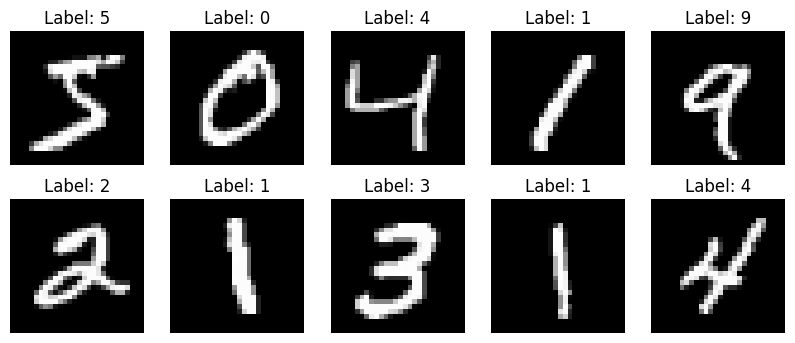

In [19]:
import matplotlib.pyplot as plt

dataset = MNISTFewShotDataset(mode='train')
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    img, label = dataset[i]
    img = img.squeeze(0).numpy()  # Convertir a numpy array para visualizar
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()


## Train.py

In [51]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [52]:
from tqdm import tqdm
import numpy as np
import torch
import os


def init_seed(opt):
    '''
    Disable cudnn to maximize reproducibility
    '''
    torch.cuda.cudnn_enabled = False
    np.random.seed(opt.manual_seed)
    torch.manual_seed(opt.manual_seed)
    torch.cuda.manual_seed(opt.manual_seed)


def init_dataset(opt, mode):
    dataset = MNISTFewShotDataset(mode=mode, root=opt.dataset_root)
    n_classes = len(np.unique(dataset.y))
    if n_classes < opt.classes_per_it_tr or n_classes < opt.classes_per_it_val:
        raise(Exception('There are not enough classes in the dataset in order ' +
                        'to satisfy the chosen classes_per_it. Decrease the ' +
                        'classes_per_it_{tr/val} option and try again.'))
    return dataset

In [53]:
def init_sampler(opt, labels, mode):
    if 'train' in mode:
        classes_per_it = opt.classes_per_it_tr
        num_samples = opt.num_support_tr + opt.num_query_tr
    else:
        classes_per_it = opt.classes_per_it_val
        num_samples = opt.num_support_val + opt.num_query_val

    return PrototypicalBatchSampler(labels=labels,
                                    classes_per_it=classes_per_it,
                                    num_samples=num_samples,
                                    iterations=opt.iterations)


def init_dataloader(opt, mode):
    dataset = init_dataset(opt, mode)
    sampler = init_sampler(opt, dataset.y, mode)
    dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler)
    return dataloader


def init_protonet(opt):
    '''
    Initialize the ProtoNet
    '''
    device = 'cuda:0' if torch.cuda.is_available() and opt.cuda else 'cpu'
    model = ProtoNet().to(device)
    return model


def init_optim(opt, model):
    '''
    Initialize optimizer
    '''
    return torch.optim.Adam(params=model.parameters(),
                            lr=opt.learning_rate)


def init_lr_scheduler(opt, optim):
    '''
    Initialize the learning rate scheduler
    '''
    return torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                           gamma=opt.lr_scheduler_gamma,
                                           step_size=opt.lr_scheduler_step)


def save_list_to_file(path, thelist):
    with open(path, 'w') as f:
        for item in thelist:
            f.write("%s\n" % item)

In [54]:
def train(opt, tr_dataloader, model, optim, lr_scheduler, val_dataloader=None):
    '''
    Train the model with the prototypical learning algorithm
    '''

    device = 'cuda:0' if torch.cuda.is_available() and opt.cuda else 'cpu'

    if val_dataloader is None:
        best_state = None
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    best_acc = 0

    best_model_path = os.path.join(opt.experiment_root, 'best_model.pth')
    last_model_path = os.path.join(opt.experiment_root, 'last_model.pth')

    for epoch in range(opt.epochs):
        print('=== Epoch: {} ==='.format(epoch))
        tr_iter = iter(tr_dataloader)
        model.train()
        for batch in tqdm(tr_iter):
            optim.zero_grad()
            x, y = batch
            x, y = x.to(device), y.to(device)
            model_output = model(x)
            loss, acc = prototypical_loss(model_output, target=y,
                                n_support=opt.num_support_tr)
            loss.backward()
            optim.step()
            train_loss.append(loss.item())
            train_acc.append(acc.item())
        avg_loss = np.mean(train_loss[-opt.iterations:])
        avg_acc = np.mean(train_acc[-opt.iterations:])
        print('Avg Train Loss: {}, Avg Train Acc: {}'.format(avg_loss, avg_acc))
        lr_scheduler.step()
        if val_dataloader is None:
            continue
        val_iter = iter(val_dataloader)
        model.eval()
        for batch in val_iter:
            x, y = batch
            x, y = x.to(device), y.to(device)
            model_output = model(x)
            loss, acc = prototypical_loss(model_output, target=y,
                                n_support=opt.num_support_val)
            val_loss.append(loss.item())
            val_acc.append(acc.item())
        avg_loss = np.mean(val_loss[-opt.iterations:])
        avg_acc = np.mean(val_acc[-opt.iterations:])
        postfix = ' (Best)' if avg_acc >= best_acc else ' (Best: {})'.format(
            best_acc)
        print('Avg Val Loss: {}, Avg Val Acc: {}{}'.format(
            avg_loss, avg_acc, postfix))
        if avg_acc >= best_acc:
            torch.save(model.state_dict(), best_model_path)
            best_acc = avg_acc
            best_state = model.state_dict()

    torch.save(model.state_dict(), last_model_path)

    for name in ['train_loss', 'train_acc', 'val_loss', 'val_acc']:
        save_list_to_file(os.path.join(opt.experiment_root,
                                       name + '.txt'), locals()[name])

    return best_state, best_acc, train_loss, train_acc, val_loss, val_acc


In [69]:
def test(opt, test_dataloader, model):
    '''
    Test the model trained with the prototypical learning algorithm
    '''
    device = 'cuda:0' if torch.cuda.is_available() and opt.cuda else 'cpu'
    avg_acc = list()
    for epoch in range(10):
        test_iter = iter(test_dataloader)
        for batch in test_iter:
            x, y = batch
            x, y = x.to(device), y.to(device)
            model_output = model(x)
            _, acc = prototypical_loss(model_output, target=y,
                             n_support=opt.num_support_val)
            avg_acc.append(acc.item())
            #print('target',y)
            #print('output',model_output)
            #preds = model_output.argmax(dim=1)  # Clases predichas
            #print("Predicciones:", preds.numpy())
            #print("Etiquetas reales:", y.numpy())
            
            # Extraer predicciones desde model_output
            with torch.no_grad():
                preds = model_output.argmax(dim=1) 

            etiquetas_reales = y.cpu().numpy()
            
            print("Predicciones:", preds.cpu().numpy())
            print("Etiquetas reales:", y.cpu().numpy())

    avg_acc = np.mean(avg_acc)
    print('Test Acc: {}'.format(avg_acc))

    return avg_acc

In [60]:
def eval(opt):
    '''
    Initialize everything and train
    '''
    options = get_parser().parse_args()

    if torch.cuda.is_available() and not options.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

    init_seed(options)
    test_dataloader = init_dataset(options)[-1]
    model = init_protonet(options)
    model_path = os.path.join(opt.experiment_root, 'best_model.pth')
    model.load_state_dict(torch.load(model_path))

    test(opt=options,
         test_dataloader=test_dataloader,
         model=model)

## Main

In [70]:
import os
import sys
import torch

options, unknown = get_parser().parse_known_args()
if not os.path.exists(options.experiment_root):
    os.makedirs(options.experiment_root)



if torch.cuda.is_available() and not options.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

init_seed(options)

tr_dataloader = init_dataloader(options, 'train')
val_dataloader = init_dataloader(options, 'val')
# trainval_dataloader = init_dataloader(options, 'trainval')
test_dataloader = init_dataloader(options, 'test')

model = init_protonet(options)
optim = init_optim(options, model)
lr_scheduler = init_lr_scheduler(options, optim)
res = train(opt=options,
            tr_dataloader=tr_dataloader,
            val_dataloader=val_dataloader,
            model=model,
            optim=optim,
            lr_scheduler=lr_scheduler)
best_state, best_acc, train_loss, train_acc, val_loss, val_acc = res
print('Testing with last model..')
test(opt=options,
        test_dataloader=test_dataloader,
        model=model)

model.load_state_dict(best_state)
print('Testing with best model..')
test(opt=options,
        test_dataloader=test_dataloader,
        model=model)

/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_1024/2916475382.py:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  self.indexes[label_idx, np.where(np.isnan(self.indexes[label_idx]))[0][0]] = idx


=== Epoch: 0 ===


100%|██████████| 100/100 [00:05<00:00, 18.17it/s]


Avg Train Loss: 0.37538806080818177, Avg Train Acc: 0.8849999985098839
Avg Val Loss: 0.15357030294835566, Avg Val Acc: 0.9523333275318145 (Best)
=== Epoch: 1 ===


100%|██████████| 100/100 [00:05<00:00, 18.13it/s]


Avg Train Loss: 0.14774383271113037, Avg Train Acc: 0.9577999979257583
Avg Val Loss: 0.11949118748307228, Avg Val Acc: 0.9643333315849304 (Best)
=== Epoch: 2 ===


100%|██████████| 100/100 [00:05<00:00, 18.10it/s]


Avg Train Loss: 0.1148321739025414, Avg Train Acc: 0.9635999995470047
Avg Val Loss: 0.08806222526356577, Avg Val Acc: 0.9716666686534882 (Best)
=== Epoch: 3 ===


100%|██████████| 100/100 [00:05<00:00, 17.84it/s]


Avg Train Loss: 0.09008717717137188, Avg Train Acc: 0.9746000027656555
Avg Val Loss: 0.0732528337277472, Avg Val Acc: 0.9774000066518783 (Best)
=== Epoch: 4 ===


100%|██████████| 100/100 [00:05<00:00, 17.73it/s]


Avg Train Loss: 0.07801196894375607, Avg Train Acc: 0.975400002002716
Avg Val Loss: 0.07448539647273719, Avg Val Acc: 0.9783333414793014 (Best)
=== Epoch: 5 ===


100%|██████████| 100/100 [00:05<00:00, 17.29it/s]


Avg Train Loss: 0.06093825921649113, Avg Train Acc: 0.9812000012397766
Avg Val Loss: 0.05909852617420256, Avg Val Acc: 0.9828666800260544 (Best)
=== Epoch: 6 ===


100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


Avg Train Loss: 0.05219377441331744, Avg Train Acc: 0.9850000041723251
Avg Val Loss: 0.05817748484201729, Avg Val Acc: 0.9819333428144454 (Best: 0.9828666800260544)
=== Epoch: 7 ===


100%|██████████| 100/100 [00:05<00:00, 17.29it/s]


Avg Train Loss: 0.050572655419819056, Avg Train Acc: 0.9848000019788742
Avg Val Loss: 0.05743889353703707, Avg Val Acc: 0.9822666758298874 (Best: 0.9828666800260544)
=== Epoch: 8 ===


100%|██████████| 100/100 [00:05<00:00, 17.13it/s]


Avg Train Loss: 0.04986234589479863, Avg Train Acc: 0.9848000049591065
Avg Val Loss: 0.05634854425676167, Avg Val Acc: 0.9826666766405106 (Best: 0.9828666800260544)
Testing with last model..
Predicciones: [7 1 5 7 1 7 0 2 7 6 8 1 7 1 7 5 7 8 3 1 8 1 8 1 1 1 8 1 1 1 7 1 7 0 4 7 0
 2 8 7 4 6 1 7 7 1 9 8 0 1 1 7 1 9 6 6 4 1 6 9 7 0 7 6 7 0 7 1 8 0 0 5 7 6
 1 1 1 9 0 7 0 1 2 7 9 4 7 7 0 6 8 1 7 1 5 9 7 1 7 4 8 8 0 1 1 7 0 0 4 8 7
 6 7 8 7 9 1 6 1 6 6 4 7 7 9 7 8 0 6 1 1 3 7 9 5 8 1 7 3 4 7 4 2 1 1 9 7 1
 7 0 1 4 6 4 8 8 7 7 7 7 1 0 1 8 6 7 7 8 4 0 1 7 9 1 1 7 0 1 5 7 9 7 1 5 9
 9 0 0 7 7 6 1 7 6 1 1 9 1 7 7]
Etiquetas reales: [8 4 5 8 7 6 7 6 6 2 0 4 3 9 5 9 3 9 6 9 8 7 9 9 5 9 8 5 4 3 3 4 3 4 1 8 7
 6 0 6 1 2 9 5 1 9 0 8 7 3 4 6 4 5 2 2 1 1 2 0 3 7 6 2 3 8 5 4 0 1 7 8 3 2
 4 9 4 0 7 8 7 4 6 3 0 1 1 5 7 2 2 3 3 7 5 0 5 5 3 1 8 9 7 7 5 1 8 7 1 8 8
 2 6 0 3 0 9 2 9 2 2 1 6 8 0 5 8 7 2 4 4 6 8 0 0 9 9 5 6 1 3 1 6 4 1 0 1 4
 1 4 9 1 2 1 2 0 3 3 5 6 9 7 9 2 2 6 5 9 1 8 9 3 0 4 7 8 7 5 6 3 0 6 4

np.float64(0.9833200085759163)

## Extras

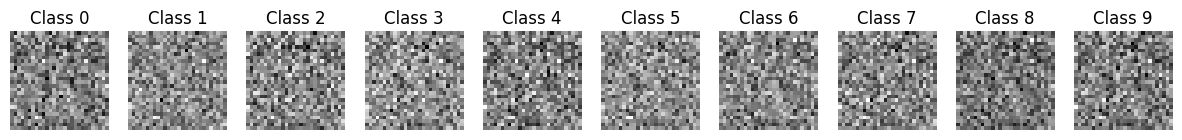

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_prototypes(model, test_dataloader, n_classes=10, img_size=(28, 28), n_support=5):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, targets in test_dataloader:
            images = images.to(next(model.parameters()).device) 
            emb = model(images)  
            embeddings.append(emb.cpu())  
            labels.append(targets.cpu())

    embeddings = torch.cat(embeddings, dim=0)  
    labels = torch.cat(labels, dim=0) 

    prototypes = model.get_prototypes(embeddings, labels, n_support)

    if hasattr(model, "decoder"):
        print("Usando decoder para reconstruir imágenes a partir de prototipos.")
        prototypes = model.decoder(prototypes).cpu().detach()
    else:
        if prototypes.shape[1] < img_size[0] * img_size[1]:  
            linear_map = torch.nn.Linear(prototypes.shape[1], img_size[0] * img_size[1])
            prototypes = linear_map(prototypes)
        
        lado = int(prototypes.shape[1] ** 0.5)
        if lado * lado == prototypes.shape[1]:  
            prototypes = prototypes.view(n_classes, 1, lado, lado)
        else:
            raise ValueError(f"Los prototipos no tienen una forma adecuada para imágenes: {prototypes.shape}")

    try:
        if prototypes.dim() == 2:  
            lado = int(prototypes.shape[1] ** 0.5)
            if lado * lado == prototypes.shape[1]:
                prototypes = prototypes.view(n_classes, 1, lado, lado)
            else:
                raise ValueError("Los prototipos no tienen una forma adecuada para imágenes.")
        elif prototypes.dim() == 4:  
            if prototypes.shape[1] == 1 or prototypes.shape[1] == 3:  
                pass  
            else:
                prototypes = prototypes[:, 0, :, :]  
    except (RuntimeError, ValueError) as e:
        print(f"Error en reshape: {e}")
        return

    fig, axes = plt.subplots(1, n_classes, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(prototypes[i].detach().numpy().squeeze(), cmap='gray')
        ax.set_title(f'Class {i}')
        ax.axis('off')
    plt.show()

visualize_prototypes(model, test_dataloader, n_classes=10, img_size=(28, 28), n_support=5)


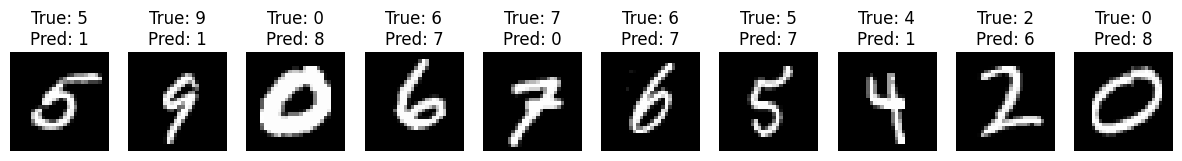

In [28]:
import torch
import matplotlib.pyplot as plt

def test_and_visualize(model, test_dataloader, n_samples=10, img_size=(28, 28)):
    model.eval()
    
    images_list = []
    true_labels = []
    predicted_labels = []
    pred_prob = []
    
    with torch.no_grad():
        for images, targets in test_dataloader:
            images = images.to(next(model.parameters()).device)  
            outputs = model(images)  # Obtener predicciones
            preds = outputs.argmax(dim=1).cpu()  # Convertir logits a etiquetas
            images_list.append(images.cpu())
            true_labels.append(targets.cpu())
            predicted_labels.append(preds)
            pred_prob.append(outputs.softmax(dim=1).cpu())

            if len(images_list) * images.shape[0] >= n_samples:
                break  # Tomar solo los primeros n_samples ejemplos

    # print(predicted_labels)
    # print(len(pred_prob[0][0]))
    # Concatenar los datos recolectados
    images_list = torch.cat(images_list, dim=0)[:n_samples]
    true_labels = torch.cat(true_labels, dim=0)[:n_samples]
    predicted_labels = torch.cat(predicted_labels, dim=0)[:n_samples]
    

    # Graficar imágenes con etiquetas reales y predichas
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images_list[i].squeeze().numpy(), cmap='gray')
        ax.set_title(f'True: {true_labels[i].item()}\nPred: {predicted_labels[i].item()}')
        ax.axis('off')

    plt.show()

# Llamar a la función para probar el modelo y visualizar predicciones
test_and_visualize(model, test_dataloader, n_samples=10, img_size=(28, 28))


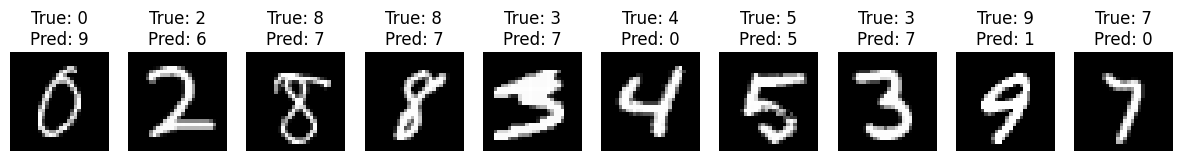

In [29]:
import torch
import matplotlib.pyplot as plt

def test_and_visualize(model, test_dataloader, n_samples=10):
    model.eval()
    
    images_list = []
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for images, targets in test_dataloader:
            images = images.to(next(model.parameters()).device)  
            outputs = model(images) 
            preds = outputs.argmax(dim=1).cpu()  

            images_list.append(images.cpu())
            true_labels.append(targets.cpu())
            predicted_labels.append(preds)

            if sum(len(batch) for batch in images_list) >= n_samples:
                break

    # Concatenar y truncar al tamaño deseado
    images_list = torch.cat(images_list, dim=0)[:n_samples]
    true_labels = torch.cat(true_labels, dim=0)[:n_samples]
    predicted_labels = torch.cat(predicted_labels, dim=0)[:n_samples]

    # Graficar imágenes con etiquetas reales y predichas
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
    for i, ax in enumerate(axes):
        img = images_list[i]
        if img.dim() == 3 and img.shape[0] == 1:  # (1, 28, 28) -> (28, 28)
            img = img.squeeze(0)
        ax.imshow(img.numpy(), cmap='gray')
        ax.set_title(f'True: {true_labels[i].item()}\nPred: {predicted_labels[i].item()}')
        ax.axis('off')

    plt.show()

# Llamar a la función para probar el modelo y visualizar predicciones
test_and_visualize(model, test_dataloader, n_samples=10)


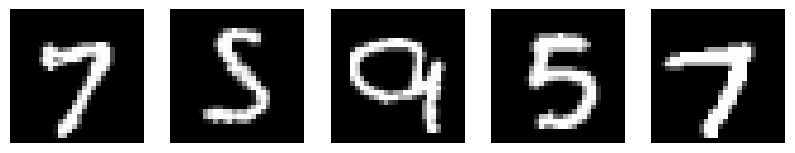

In [30]:
import matplotlib.pyplot as plt

# Mostrar algunas imágenes de test
test_images, _ = next(iter(test_dataloader))
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(test_images[i].squeeze().numpy(), cmap='gray')
    ax.axis('off')
plt.show()


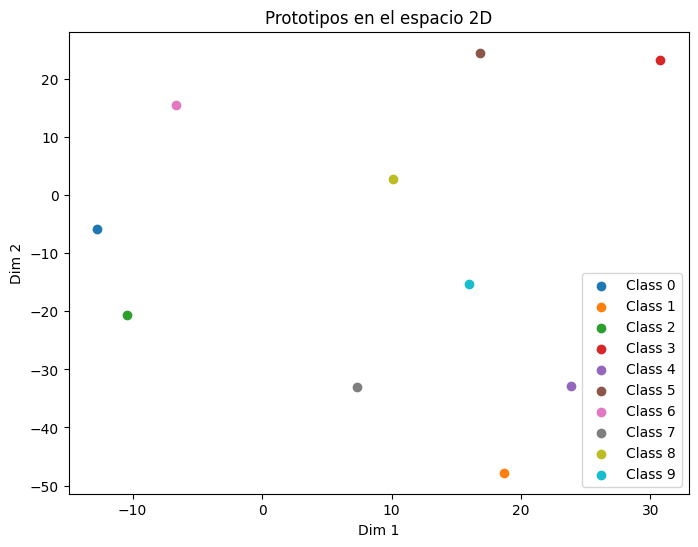

In [31]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_prototypes_tsne(model, dataset, n_classes=10):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for i in range(len(dataset)):
            img, label = dataset[i]
            img = img.unsqueeze(0)  # Añadir batch dimension
            embedding = model.encoder(img)  # Extraer embedding
            embeddings.append(embedding)
            labels.append(label)

    embeddings = torch.cat(embeddings)  # Convertir en tensor
    labels = torch.tensor(labels)

    prototypes = []
    for c in range(n_classes):
        class_embeddings = embeddings[labels == c]
        if len(class_embeddings) > 0:
            proto = class_embeddings.mean(dim=0)  # Media de embeddings por clase
            prototypes.append(proto)

    if len(prototypes) < 2:
        print("No hay suficientes prototipos para visualizar con t-SNE.")
        return

    # Convertir a numpy y asegurar que sea 2D (num_prototypes, features)
    prototypes = torch.stack(prototypes).cpu().numpy()
    prototypes = prototypes.reshape(prototypes.shape[0], -1)  # Asegurar que es 2D

    # Ajustar perplexity según el número de prototipos
    perplexity_value = min(len(prototypes) - 1, 5)

    # Aplicar t-SNE para reducir a 2D
    tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
    proto_2d = tsne.fit_transform(prototypes)

    # Graficar los prototipos en 2D
    plt.figure(figsize=(8, 6))
    for i in range(len(prototypes)):
        plt.scatter(proto_2d[i, 0], proto_2d[i, 1], label=f'Class {i}')
    plt.legend()
    plt.title('Prototipos en el espacio 2D')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.show()

# Llamar a la función
visualize_prototypes_tsne(model, dataset=test_dataloader.dataset, n_classes=10)


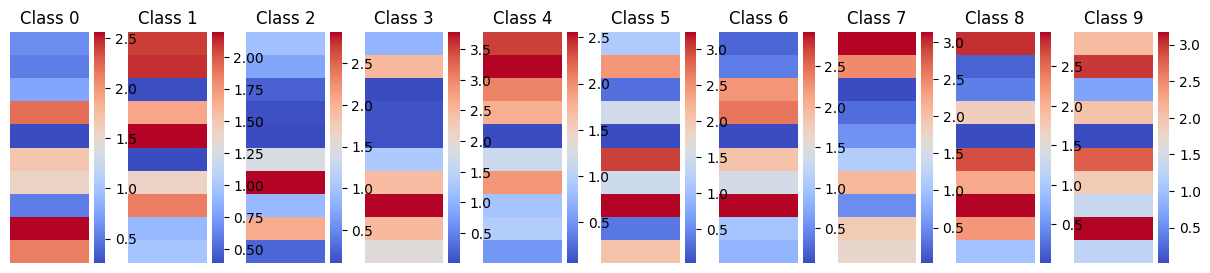

In [32]:
import seaborn as sns

def visualize_prototypes_heatmap(model, dataset, n_classes=10):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for i in range(len(dataset)):
            img, label = dataset[i]
            img = img.unsqueeze(0)
            embedding = model.encoder(img)
            embeddings.append(embedding)
            labels.append(label)

    embeddings = torch.cat(embeddings)
    labels = torch.tensor(labels)

    prototypes = []
    for c in range(n_classes):
        class_embeddings = embeddings[labels == c]
        if len(class_embeddings) > 0:
            proto = class_embeddings.mean(dim=0)
            prototypes.append(proto)

    prototypes = torch.stack(prototypes).cpu().numpy()

    # Visualizar como heatmap
    fig, axes = plt.subplots(1, n_classes, figsize=(15, 3))
    for i, ax in enumerate(axes):
        #print(prototypes[i].shape)
        sns.heatmap(prototypes[i].reshape(10, 1), cmap="coolwarm", ax=ax)
        ax.set_title(f'Class {i}')
        ax.axis('off')

    plt.show()

# Llamar a la función
visualize_prototypes_heatmap(model, dataset=test_dataloader.dataset, n_classes=10)
